In [108]:
!pip install keras
!pip install imbalanced-learn

In [109]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE, KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

import tensorflow as rf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [110]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Mounting Google Drive and EDA

In [111]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/legal_text_classification.csv')
df.head()

df = df.drop(['case_id'], axis=1)
# df = df.head(2000)
df['case_outcome'][0]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'cited'

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_outcome  24985 non-null  object
 1   case_title    24985 non-null  object
 2   case_text     24809 non-null  object
dtypes: object(3)
memory usage: 585.7+ KB


In [113]:
df.isnull().sum()

,0
case_outcome,0
case_title,0
case_text,176


In [114]:
df.shape

(24985, 3)

In [115]:
df = df.dropna(how='any', axis=0)
df.isnull().sum()

,0
case_outcome,0
case_title,0
case_text,0


In [116]:
df.shape

(24809, 3)

In [117]:
categorical_info = df['case_outcome'].value_counts()
categorical_info
type(categorical_info)

pandas.core.series.Series

# Bar plot of categories

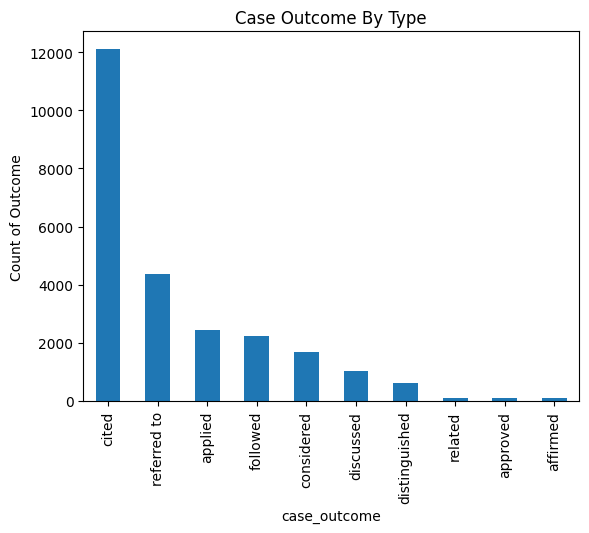

In [118]:
categorical_info.plot(kind='bar', title='Case Outcome By Type', ylabel='Count of Outcome')

# Display the plot
plt.show()

# Pi Plot of categories

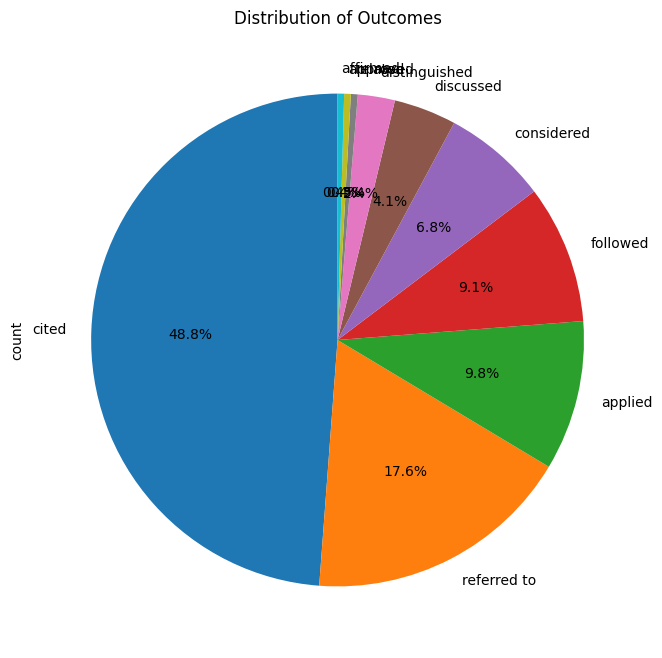

In [119]:
categorical_info.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(8, 8))

# Add a title (optional)
plt.title('Distribution of Outcomes')

# Display the plot
plt.show()

<Axes: ylabel='Density'>

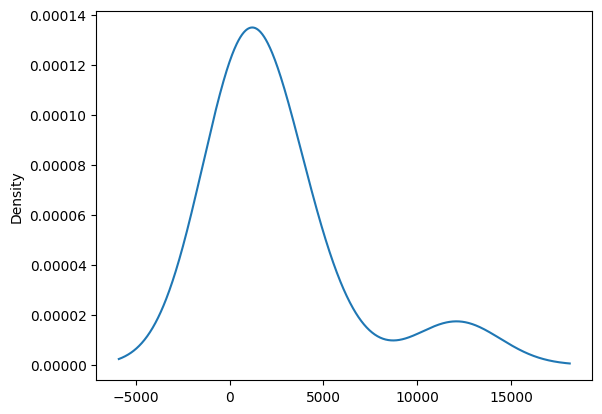

In [120]:
categorical_info.plot.kde()

In [121]:
import string
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text):
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def cleanText(df):
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
  df = df.replace(to_replace=r'[^\w\s]', value='', regex=True)
  df = df.replace(to_replace=r'\d+', value='', regex=True)
  df = df.replace(to_replace=r'\s+[a-zA-Z]\s+', value='', regex=True)
  df = df.apply(lambda x: remove_punctuation(x) if isinstance(x, str) else x)
  df = df.apply(lambda x: remove_stopwords(x) if isinstance(x, str) else x)
  return df

df = cleanText(df)

df.head()

/tmp/ipython-input-121-3899175963.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,case_outcome,case_title,case_text
0,cited,alpine hardwood aust pty ltdhardys pty ltd no ...,ordinarily that discretion will be exercised s...
1,cited,blacklipovac fca alr,the general principles governing the exercise ...
2,cited,colgate palmolive cocussons pty ltd fcr,ordinarily that discretion will be exercised s...
3,cited,dais studio pty ltdbullett creative pty ltd fca,the general principles governing the exercise ...
4,cited,dr martens australia pty ltdfiggins holdings p...,the preceding general principles inform the ex...


In [123]:
X_raw = df.drop('case_outcome', axis=1)
y_raw = df['case_outcome']
le = LabelEncoder()
y = le.fit_transform(y_raw)
y_raw = y
y_raw

array([3, 3, 3, ..., 3, 6, 6])

In [124]:
tfidf=TfidfVectorizer(max_features=100, ngram_range=(1,2))
X_case_text=tfidf.fit_transform(X_raw.case_text)
X_case_title = tfidf.fit_transform(X_raw.case_title)
X = pd.concat([pd.DataFrame(X_case_text.toarray()), pd.DataFrame(X_case_title.toarray())], axis=1)
y_raw = pd.DataFrame(y_raw)

In [125]:
x_train_raw, x_test_raw, y_train_raw, y_test = train_test_split(X, y_raw, test_size=0.2, random_state=434)
y_train_raw.shape

(19847, 1)

In [126]:
sm = SMOTE(sampling_strategy='minority')
x_train, y_train = sm.fit_resample(x_train_raw, y_train_raw)
x_test, y_test = sm.fit_resample(x_test_raw, y_test)
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.080632,0.123551,...,0.277548,0.0,0.339183,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.054086,0.000000,0.120990,0.122433,0.0,0.000000,0.000000,0.000000,0.052138,0.079890,...,0.277443,0.0,0.339055,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.100926,0.068801,0.156648,0.0,0.000000,0.000000,0.109837,0.088945,0.000000,...,0.363902,0.0,0.444714,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.061249,0.046485,0.0,0.000000,0.157615,0.048891,0.000000,0.060664,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.047360,0.032285,0.098010,0.0,0.043055,0.000000,0.000000,0.041738,0.063954,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
def model(model_name,X_train,y_train,X_test,y_test):
    # Combine text columns
    # X_train_combined = X_train['case_title'] + ' ' + X_train['case_text']
    # X_test_combined = X_test['case_title'] + ' ' + X_test['case_text']

    pipeline=Pipeline([
    #('tfidf', TfidfVectorizer(max_features=100, ngram_range=(1,2))),transform the texts into the vectorized input variables X
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    return score

In [128]:
mnb=model(MultinomialNB(),x_train,y_train,x_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

              precision    recall  f1-score   support

           0       0.99      0.47      0.64      2436
           1       0.00      0.00      0.00       500
           2       0.00      0.00      0.00        17
           3       0.48      0.84      0.61      2436
           4       0.00      0.00      0.00       342
           5       0.00      0.00      0.00       189
           6       0.00      0.00      0.00       125
           7       0.27      0.06      0.10       451
           8       0.30      0.01      0.01       861
           9       0.01      0.73      0.02        26

    accuracy                           0.44      7383
   macro avg       0.20      0.21      0.14      7383
weighted avg       0.54      0.44      0.42      7383

[[1151    0    0  170    0    0    0    0    0 1115]
 [   0    0    0  452    0    0    0    9    3   36]
 [   0    0    0   14    0    0    0    0    0    3]
 [   1    0    0 2058    0    0    0   38    3  336]
 [   1    0    0  268    0   

In [129]:
rf=model(RandomForestClassifier(),x_train,y_train,x_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.88      0.01      0.01      2436
           1       0.54      0.15      0.23       500
           2       0.20      0.06      0.09        17
           3       0.37      0.94      0.53      2436
           4       0.57      0.11      0.19       342
           5       0.38      0.06      0.10       189
           6       0.80      0.16      0.27       125
           7       0.72      0.24      0.35       451
           8       0.76      0.29      0.42       861
           9       0.02      0.38      0.04        26

    accuracy                           0.38      7383
   macro avg       0.53      0.24      0.22      7383
weighted avg       0.63      0.38      0.28      7383

[[  14    0    0 2004    0    0    0    0    6  412]
 [   0   74    0  398    6    2    0    4   15    1]
 [   0    0    1   16    0    0    0    0    0    0]
 [   1   35    4 2301   12   12    3   25   34    9]
 [   0    7    0  282   39   

In [130]:
xgb=model(XGBClassifier(),x_train,y_train,x_test,y_test)

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [132]:
svc=model(SVC(),x_train,y_train,x_test,y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning

              precision    recall  f1-score   support

           0       0.99      0.64      0.78      2436
           1       0.00      0.00      0.00       500
           2       0.00      0.00      0.00        17
           3       0.44      0.99      0.61      2436
           4       0.00      0.00      0.00       342
           5       0.00      0.00      0.00       189
           6       0.00      0.00      0.00       125
           7       0.57      0.02      0.03       451
           8       0.67      0.02      0.04       861
           9       0.04      0.46      0.08        26

    accuracy                           0.54      7383
   macro avg       0.27      0.21      0.15      7383
weighted avg       0.59      0.54      0.47      7383

[[1566    0    0  634    0    0    0    0    0  236]
 [   0    0    0  494    0    0    0    2    1    3]
 [   0    0    0   17    0    0    0    0    0    0]
 [   3    0    0 2412    0    0    0    1    5   15]
 [   1    0    0  337    0   

In [ ]:
models = pd.DataFrame({
    'Model':['MNB','RF','XGBoost', 'SVM'],
    'Accuracy_score' :[mnb ,rf, xgb, svc]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)

In [ ]:
X_raw = df.drop('case_outcome', axis=1)
y_raw = df['case_outcome']
le = LabelEncoder()
y = le.fit_transform(y_raw)
y_raw = y
y_raw

In [ ]:
tfidf=TfidfVectorizer(max_features=100, ngram_range=(1,2))
X_case_text=tfidf.fit_transform(X_raw.case_text)
X_case_title = tfidf.fit_transform(X_raw.case_title)
X = pd.concat([pd.DataFrame(X_case_text.toarray()), pd.DataFrame(X_case_title.toarray())], axis=1)
y_raw = pd.DataFrame(y_raw)
# y_raw = tfidf.fit_transform(y_raw)
# y_raw.head()

In [ ]:
x_train_raw, x_test_raw, y_train_raw, y_test = train_test_split(X, y_raw, test_size=0.2, random_state=434)
y_train_raw.shape

In [ ]:
sm = SMOTE(sampling_strategy='minority')
x_train, y_train = sm.fit_resample(x_train_raw, y_train_raw)
x_test, y_test = sm.fit_resample(x_test_raw, y_test)

# sm = KMeansSMOTE(k_neighbors=2, cluster_balance_threshold=2, random_state=42)
# x_train, y_train = sm.fit_resample(x_train_raw, y_train_raw)

In [ ]:
# Define parameter
# vocab_size = 500 # Not needed for Dense layers with TF-IDF
# embedding_dim = 16 # Not needed for Dense layers with TF-IDF
drop_value = 0.2
n_dense = 16
# n_lstm = 128 # Not needed for Dense layers
# drop_lstm = 0.2 # Not needed for Dense layers

model = Sequential()
model.add(Dense(n_dense, activation='relu', input_shape=(x_train.shape[1],))) # Add Dense layer for 2D input
model.add(Dropout(drop_value)) # Add Dropout after Dense layer

# The number of output units in the final Dense layer should match the number of classes in your target variable
# Assuming y_train has multiple classes based on the categorical_info output
num_classes = len(categorical_info) # Get the number of unique classes from categorical_info
model.add(Dense(num_classes, activation='softmax')) # Use softmax for multi-class classification
print(x_train.shape)
print(y_train_raw.shape)
model.summary()

In [ ]:
model.compile(loss = 'categorical_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the target variables
y_train_encoded = to_categorical(y_train, num_classes=num_classes) # Use the resampled y_train
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


num_epochs = 10
# early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(x_train,
                     y_train_encoded, # Use the one-hot encoded training data
                     epochs=num_epochs,
                     validation_data=(x_test, y_test_encoded), # Use the one-hot encoded validation data
                    #  callbacks =[early_stop],
                     verbose=2)

In [ ]:
model.evaluate(x_test, y_test_encoded)

In [ ]:
train_dense_results = model.evaluate(x_train, np.asarray(y_train_encoded), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(x_test, np.asarray(y_test_encoded), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

In [ ]:
x_predict_text = [
    """
    It was not suggested in this proceeding that, so far as a Commonwealth revenue debt is concerned, there is any express statutory provision which alters the usual position which prevails as between creditor and debtor when a cheque is given in payment of a debt. That usual position was expressed by Mason CJ, Brennan, Deane, Dawson and Toohey JJ in National Australia Bank v KDS Construction Services Pty Ltd [1987] HCA 65 ; (1987) 163 CLR 668 , at 676 to be as follows: Generally speaking, when a cheque is given in payment of a debt, it operates as a conditional payment. The payment is subject to a condition that the cheque be paid on presentation. If it is dishonoured the debt revives. Although it is sometimes said that the remedy for the primary debt is suspended, the suspension is no more than a consequence of the conditional nature of the payment: Tilley v Official Receiver in Bankruptcy [1960] HCA 86 ; (1960) 103 CLR 529 , at pp 532-533, 535-536, 537. The condition is a condition subsequent so that, if the cheque is met, it ranks as an actual payment from the time it was given. Subject to non-fulfilment of the condition subsequent, the payment is complete at the time when the cheque is accepted by the creditor: Thomson v Moyse (1961) AC 967 , at p 1004. 14 It was submitted for the Deputy Commissioner that, in the events which had transpired in this case, that usual position had been altered by the signification by the Deputy Commissioner that he would agree to the dismissal of the winding up application once the proceeds of the cheque had been cleared. It seems to me though that the evidence is more consistent with the Deputy Commissioner's adopting a position which was in accordance with the general position when a cheque is given in payment of a debt. It has been accepted subject to a condition that the cheque would be paid on presentation. Subject to the fulfilment of that condition, payment of the then outstanding amount of the debt due to the Commonwealth and payable to the Commissioner was complete upon the acceptance by the Deputy Commissioner on 10 November 2008 of the cheque then proffered on behalf of Ganter. In this regard, the fact that the proffered cheque was a bank cheque may well have provided a degree of comfort to the Deputy Commissioner in deciding to accept it, but the position would have been the same in law so far as the relationship of debtor and creditor was concerned had the cheque concerned been one where the drawer was other than a bank.
    """
]
x_predict_title = ["National Australia Bank v KDS Construction Services Pty Ltd [1987] HCA 65 ; (1987) 163 CLR 668"]

def predict_spam(x_predict_text, x_predict_title):
  df_predict = pd.DataFrame({'case_text': x_predict_text, 'case_title': x_predict_title})
  df_predict = cleanText(df_predict)
  x_vector_text=tfidf.transform(df_predict.case_text)
  x_vector_title = tfidf.transform(df_predict.case_title)
  x_predict = pd.concat([pd.DataFrame(x_vector_text.toarray()), pd.DataFrame(x_vector_title.toarray())], axis=1)
  return(model.predict(x_predict))

predict_spam(x_predict_text, x_predict_title)